In [88]:
import glob
import os
import pathlib

import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import functional as F

from torchvision import transforms
from torchinfo import torchinfo
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
import torch.nn.functional as F

import random
from PIL import Image

import torchmetrics
import transformers
from torchvision.utils import save_image, make_grid
import cv2
import os, glob

import random
from numba import njit, prange

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

In [89]:
dataset_path = '../Datasets/Feature extraction/'

In [90]:
directories = glob.glob(dataset_path+'*')
len(directories)

99999

In [91]:
files = glob.glob(dataset_path+'/*/*.png', recursive = True) 
len(files)

499995

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


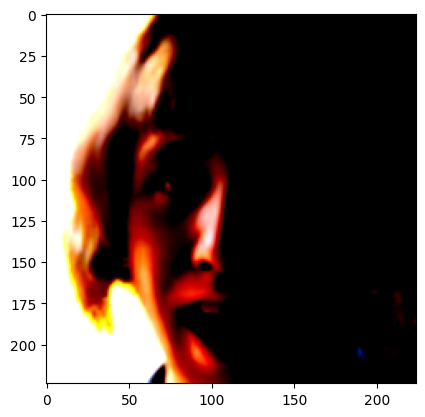

In [92]:
sizes = (224, 224)

rescale_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(sizes, antialias= False),
    transforms.Normalize(
        # mean = 0, std = 1
        mean =[0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

img = rescale_transform(Image.open(files[0]).convert("RGB")).permute(1, 2, 0).numpy()
plt.imshow(img)

Contrastive + completion

- Contrastive: masked vs true in the same representation space 
- 

In [93]:
rotate = 90
translate = (0.25, 0.25)
scale = (0.9, 1.1)
shear = 15

masker = torchvision.transforms.Compose([
    torchvision.transforms.RandomErasing(p = 1, scale = (0.35, 0.6), ratio = (0.5, 1.5), value = 0)
])

img_augment = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees = rotate, 
                                        translate = translate,
                                        scale = scale, 
                                        shear = shear, 
                                        interpolation = torchvision.transforms.InterpolationMode.BILINEAR
                                        )
])

second_augment = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(
        degrees = rotate,
        scale = scale,
        translate = [x/4 for x in translate],
        shear = shear/4,
        interpolation = torchvision.transforms.InterpolationMode.BILINEAR 
    )
])

In [94]:
class celebDataset(Dataset):
    def __init__(self, files, dirs, dataset_path, masker, preprocessor = rescale_transform, aug1 = None, aug2 = None):
        self.files = files
        self.dirs = set(dirs)
        self.datapath = dataset_path

        self.masker = masker
        self.preprocessor = preprocessor
        self.aug1 = aug1
        self.aug2 = aug2


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.preprocessor(img)

        #augment image 1
        if self.aug1 is not None:
            img = self.aug1(img)

        # masked image
        masked = self.masker(img)

        # anchor is the base-augmented image, the positive will be masked augmented2 image
        positive = self.aug2(masked)

        # contrastive part, sample negative image
        img1_pardir = set(os.path.basename(os.path.dirname(img_path)))
        img2_dir = random.choice(list(self.dirs - img1_pardir))

        #directory for sampling negative from
        chosen_dir = glob.glob(img2_dir + '/*.png')
        img2_path = random.choice(chosen_dir)

        img2 = Image.open(img2_path).convert("RGB")
        img2 = self.aug2(self.preprocessor(img2))
        

        return img, masked, positive, img2

In [95]:
dataset = celebDataset(files = files,
                       dirs = directories,
                       dataset_path = dataset_path,
                       masker = masker,
                       preprocessor = rescale_transform,
                       aug1= None,
                       aug2 = second_augment)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


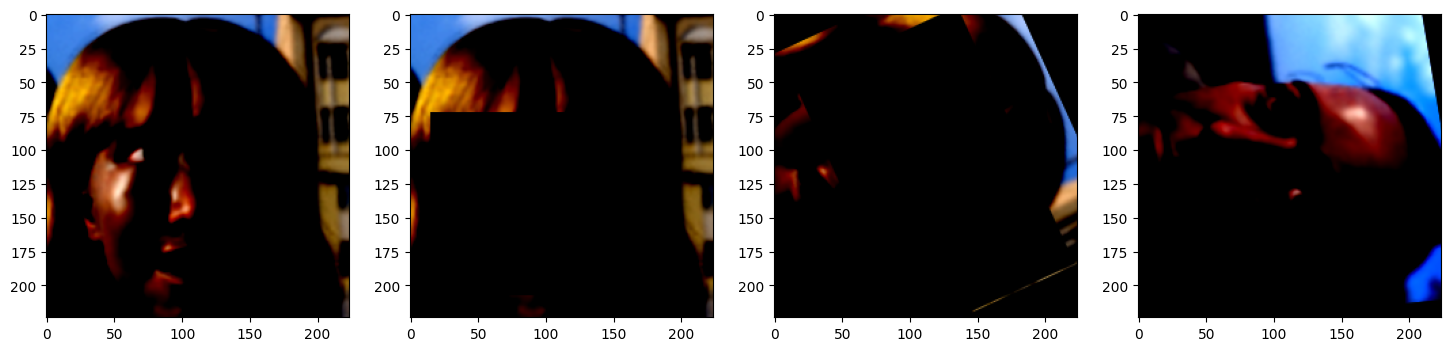

In [96]:
fig, ax = plt.subplots(1, 4, figsize = (18, 6))

ax[0].imshow(train_dataset[0][0].permute(1, 2, 0).numpy())
ax[1].imshow(train_dataset[0][1].permute(1, 2, 0).numpy())
ax[2].imshow(train_dataset[0][2].permute(1, 2, 0).numpy())
ax[3].imshow(train_dataset[0][3].permute(1, 2, 0).numpy())

In [75]:
BATCH_SIZE = 50

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)

In [ ]:
class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# class EfficientUNet_B0(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.main = efficientunet.get_efficientunet_b0(out_channels=3, concat_input=True, pretrained=True)

#     def forward(self, inpt):
#         out = self.main(inpt)
#         out = F.sigmoid(out)
#         return out

In [81]:
for x, y, z in train_dataloader:
    print(x.shape)
    break

torch.Size([50, 3, 224, 224])


In [85]:
model

Swinv2ForMaskedImageModeling(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96

In [84]:
model = transformers.Swinv2ForMaskedImageModeling.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

torchinfo.summary(model, (1, 3, 224, 224))

Some weights of Swinv2ForMaskedImageModeling were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized: ['swinv2.embeddings.mask_token', 'decoder.0.bias', 'decoder.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Swinv2Embeddings: 2, Swinv2PatchEmbeddings: 3, Conv2d: 4, LayerNorm: 3, Dropout: 3, Swinv2Stage: 4, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2PatchMerging: 5, Linear: 6, LayerNorm: 6, Swinv2Stage: 4, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2PatchMerging: 5, Linear: 6, LayerNorm: 6, Swinv2Stage: 4, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Layer: 6, Swinv2Attention: 7, Swinv2SelfAttention: 8, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10, Dropout: 9, Swinv2SelfOutput: 8, Linear: 9, Dropout: 9, LayerNorm: 7, Swinv2DropPath: 7, Swinv2Intermediate: 7, Linear: 8, GELUActivation: 8, Swinv2Output: 7, Linear: 8, Dropout: 8, LayerNorm: 7, Swinv2DropPath: 7, Swinv2PatchMerging: 5, Linear: 6, LayerNorm: 6, Linear: 9, Linear: 9, Linear: 9, Sequential: 9, Linear: 10, ReLU: 10, Linear: 10]

In [ ]:
EPOCHS = 10

# model = EfficientUNet_B0().to(device)
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=3, verbose=True, path = 'efficientunet_temp.pth')


for epoch_num in range(EPOCHS):
    train_loss = 0
    i = 0

    bar = tqdm(train_dataloader)
    for img, mask in bar:
        i+=1
        optim.zero_grad()

        img = img.to(device)
        mask = mask.to(device)
        predictions = model(mask)

        batch_loss = criterion(predictions, img)

        batch_loss.backward()
        optim.step()

        train_loss+= batch_loss.item()
        bar.set_description_str("Training loss: {:.4f}".format(train_loss/i))

    train_loss/=i

    
    with torch.no_grad():
        val_loss = 0
        i = 0
        bar = tqdm(val_dataloader)
        for img, mask in bar:
            i+=1
            optim.zero_grad()

            img = img.to(device)
            mask = mask.to(device)
            predictions = model(mask)

            batch_loss = criterion(predictions, img)

            val_loss+= batch_loss.item()
            bar.set_description_str("Validation loss: {:.4f}".format(val_loss/i))

        val_loss/=i


    print("Epoch [{}/{}], Train Loss: {:.4f}".format(epoch_num+1, EPOCHS, train_loss))
    print("Epoch [{}/{}], Val Loss: {:.4f}".format(epoch_num+1, EPOCHS, val_loss))
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        print('-'*60)
        break

Validation loss: 0.0026: 100%|██████████| 19/19 [00:02<00:00,  8.36it/s]


Epoch [1/10], Train Loss: 0.0022
Epoch [1/10], Val Loss: 0.0026
Validation loss decreased (inf --> 0.002634).  Saving model ...


Validation loss: 0.0027: 100%|██████████| 19/19 [00:02<00:00,  8.24it/s]


Epoch [2/10], Train Loss: 0.0022
Epoch [2/10], Val Loss: 0.0027
EarlyStopping counter: 1 out of 3


Validation loss: 0.0026: 100%|██████████| 19/19 [00:02<00:00,  8.38it/s]


Epoch [3/10], Train Loss: 0.0022
Epoch [3/10], Val Loss: 0.0026
Validation loss decreased (0.002634 --> 0.002578).  Saving model ...


Validation loss: 0.0026: 100%|██████████| 19/19 [00:02<00:00,  7.55it/s]


Epoch [4/10], Train Loss: 0.0022
Epoch [4/10], Val Loss: 0.0026
EarlyStopping counter: 1 out of 3


Validation loss: 0.0027: 100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


Epoch [5/10], Train Loss: 0.0021
Epoch [5/10], Val Loss: 0.0027
EarlyStopping counter: 2 out of 3


Validation loss: 0.0027: 100%|██████████| 19/19 [00:02<00:00,  7.87it/s]

Epoch [6/10], Train Loss: 0.0021
Epoch [6/10], Val Loss: 0.0027
EarlyStopping counter: 3 out of 3
Early stopping
------------------------------------------------------------


In [ ]:
with open('efficientunet_temp.pth', 'rb') as f:
    model.load_state_dict(torch.load(f))

In [ ]:
img, mask = val_dataset[90]

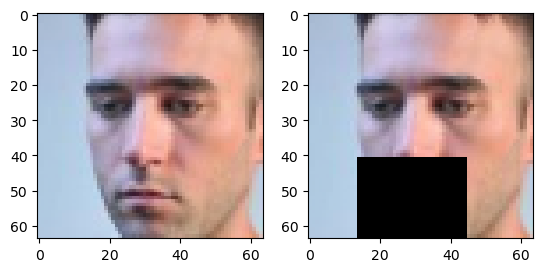

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[1].imshow(mask.cpu().permute(1, 2, 0))

In [ ]:
unmasked = model(mask[None, ...].float().to(device))

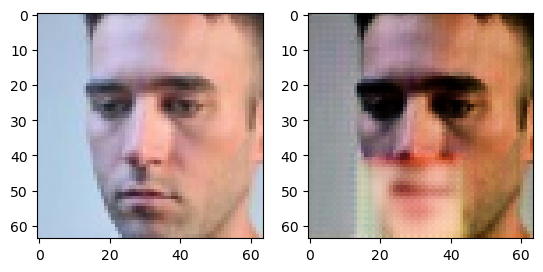

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[1].imshow(unmasked[0].detach().cpu().permute(1, 2, 0))

In [ ]:
newsize = (224, 224)
new_resize = transforms.Resize(newsize)
img = new_resize(img)
mask = new_resize(mask)

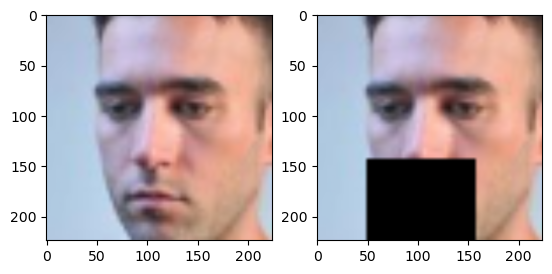

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[1].imshow(mask.cpu().permute(1, 2, 0))

In [ ]:
unmasked = model(mask[None, ...].float().to(device))

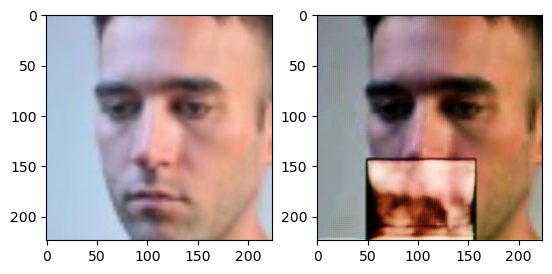

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[1].imshow(unmasked[0].detach().cpu().permute(1, 2, 0))